# Green House Gas Emissions
In this notebook we will predict GHG-emissions based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing GHG-emission data 
- Log-transforming GHG data
- Combining GHG data with Predictor data
- Exploring correlations with the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (GHG) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population, countrysize)
- Fitting simple mixed effects models with each predictor seperately (time, population, countrysize, predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import os

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [14]:
#Read file 
df = pd.read_csv('Data/ghg-emissions.csv')

df.info

df.describe

<bound method NDFrame.describe of              iso                                     Country/Region    unit  \
0            CHN                                              China  MtCO2e   
1            USA                                      United States  MtCO2e   
2            IND                                              India  MtCO2e   
3            RUS                                             Russia  MtCO2e   
4            IDN                                          Indonesia  MtCO2e   
..           ...                                                ...     ...   
190          TUV                                             Tuvalu  MtCO2e   
191          NIU                                               Niue  MtCO2e   
192          FJI                                               Fiji  MtCO2e   
193  Data source                                      Climate Watch     NaN   
194     Data for  Location: World. Sectors/Subsectors: Total inc...     NaN   

        1990     

In [15]:
#clean data 
df.drop([193, 194], inplace=True)

melted_df = pd.melt(df, id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='ghg')

#print(melted_df)

In [16]:
melted_df.describe()

,iso,Country/Region,unit,Year,ghg
count,5983,5983,5983,5983,5983.00
unique,193,193,1,31,4569.00
top,CHN,China,MtCO2e,1990,0.02
freq,31,31,5983,193,29.00


In [17]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   iso             5983 non-null   object
 1   Country/Region  5983 non-null   object
 2   unit            5983 non-null   object
 3   Year            5983 non-null   object
 4   ghg             5983 non-null   object
dtypes: object(5)
memory usage: 233.8+ KB


In [18]:
melted_df.replace('false', np.nan, inplace=True)
melted_df['Year'] = melted_df['Year'].astype(float)
melted_df['ghg'] = melted_df['ghg'].astype(float)

In [19]:

melted_df.dropna()
print(melted_df)

      iso Country/Region    unit    Year      ghg
0     CHN          China  MtCO2e  1990.0  2892.41
1     USA  United States  MtCO2e  1990.0  5448.74
2     IND          India  MtCO2e  1990.0  1020.11
3     RUS         Russia  MtCO2e  1990.0  2624.74
4     IDN      Indonesia  MtCO2e  1990.0  1140.84
...   ...            ...     ...     ...      ...
5978  COK   Cook Islands  MtCO2e  2020.0     0.07
5979  NRU          Nauru  MtCO2e  2020.0     0.05
5980  TUV         Tuvalu  MtCO2e  2020.0     0.02
5981  NIU           Niue  MtCO2e  2020.0     0.00
5982  FJI           Fiji  MtCO2e  2020.0    -0.81

[5983 rows x 5 columns]


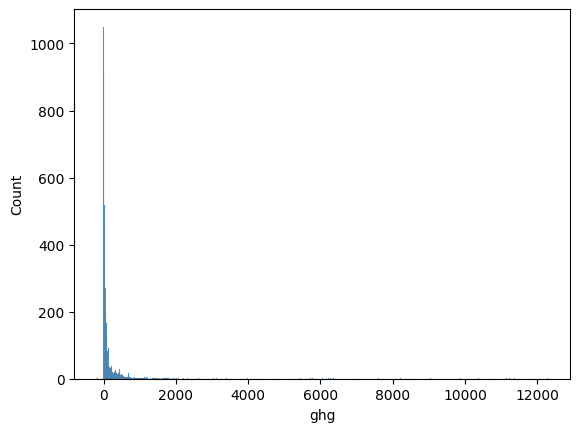

In [20]:
sns.histplot(data=melted_df, x='ghg', binwidth=10)
plt.show()

We need to transform our variable, so that the most polluting countries don't weigh to much. 

In [21]:

melted_df['log_ghg'] = np.log(melted_df['ghg'])

# Check the result
print(melted_df.head())




   iso Country/Region    unit    Year      ghg   log_ghg
0  CHN          China  MtCO2e  1990.0  2892.41  7.969845
1  USA  United States  MtCO2e  1990.0  5448.74  8.603140
2  IND          India  MtCO2e  1990.0  1020.11  6.927666
3  RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4  IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520


c:\Users\mlj\OneDrive - Aarhus Universitet\MA 2. Semester\Data Science\DataScienceExam\data_sci_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\mlj\OneDrive - Aarhus Universitet\MA 2. Semester\Data Science\DataScienceExam\data_sci_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


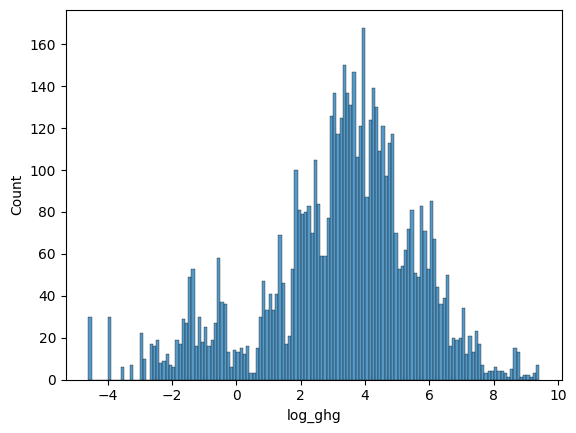

In [23]:
sns.histplot(data=melted_df, x='log_ghg', binwidth=0.1)

plt.show()

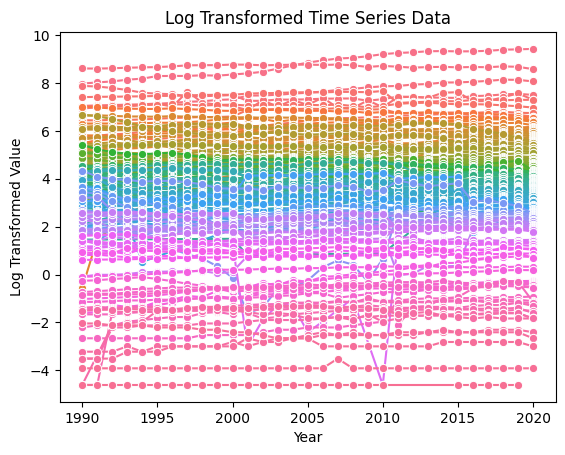

In [24]:
sns.lineplot(data=melted_df, x='Year', y='log_ghg', hue='iso', marker='o', legend=False)

# Add title and labels
plt.title('Log Transformed Time Series Data')
plt.xlabel('Year')
plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

## Add predictors to our GHG-dataset

In [ ]:
#Read predictor file 

pred = pd.read_excel('Data/predictor_data.xlsx')

print(pred)

                      Country Name Country Code  Year  Population, total  \
0                            Aruba          ABW  1960            54608.0   
1      Africa Eastern and Southern          AFE  1960        130692579.0   
2                      Afghanistan          AFG  1960          8622466.0   
3       Africa Western and Central          AFW  1960         97256290.0   
4                           Angola          AGO  1960          5357195.0   
...                            ...          ...   ...                ...   
17113        São Tomé and Principe          STP  2022                NaN   
17114                      Türkiye          TUR  2022                NaN   
17115                Taiwan, China          TWN  2022                NaN   
17116                      Vietnam          VNM  2022                NaN   
17117      Jersey, Channel Islands          JEY  2022                NaN   

       Land area (sq. km)    WGI VA    WGI PS    WGI GE    WGI RQ    WGI RL  \
0       

In [25]:
melted_df = melted_df.rename(columns={'iso': 'Country Code'})

print(melted_df)

     Country Code Country/Region    unit    Year      ghg   log_ghg
0             CHN          China  MtCO2e  1990.0  2892.41  7.969845
1             USA  United States  MtCO2e  1990.0  5448.74  8.603140
2             IND          India  MtCO2e  1990.0  1020.11  6.927666
3             RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4             IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520
...           ...            ...     ...     ...      ...       ...
5978          COK   Cook Islands  MtCO2e  2020.0     0.07 -2.659260
5979          NRU          Nauru  MtCO2e  2020.0     0.05 -2.995732
5980          TUV         Tuvalu  MtCO2e  2020.0     0.02 -3.912023
5981          NIU           Niue  MtCO2e  2020.0     0.00      -inf
5982          FJI           Fiji  MtCO2e  2020.0    -0.81       NaN

[5983 rows x 6 columns]


In [26]:
ghg_full = pd.merge(melted_df, pred, on = ['Year', 'Country Code'], how = 'inner')

print(ghg_full)

     Country Code Country/Region    unit    Year      ghg   log_ghg  \
0             CHN          China  MtCO2e  1990.0  2892.41  7.969845   
1             USA  United States  MtCO2e  1990.0  5448.74  8.603140   
2             IND          India  MtCO2e  1990.0  1020.11  6.927666   
3             RUS         Russia  MtCO2e  1990.0  2624.74  7.872737   
4             IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520   
...           ...            ...     ...     ...      ...       ...   
6114          COK   Cook Islands  MtCO2e  2020.0     0.07 -2.659260   
6115          NRU          Nauru  MtCO2e  2020.0     0.05 -2.995732   
6116          TUV         Tuvalu  MtCO2e  2020.0     0.02 -3.912023   
6117          NIU           Niue  MtCO2e  2020.0     0.00      -inf   
6118          FJI           Fiji  MtCO2e  2020.0    -0.81       NaN   

            Country Name  Population, total  Land area (sq. km)    WGI VA  \
0                  China       1.135185e+09           9388250.0       

In [29]:
ghg_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6119 entries, 0 to 6118
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6119 non-null   object 
 1   Country/Region      6119 non-null   object 
 2   unit                6119 non-null   object 
 3   Year                6119 non-null   float64
 4   ghg                 6118 non-null   float64
 5   log_ghg             6033 non-null   float64
 6   Country Name        6119 non-null   object 
 7   Population, total   5921 non-null   float64
 8   Land area (sq. km)  5797 non-null   float64
 9   WGI VA              4117 non-null   float64
 10  WGI PS              4073 non-null   float64
 11  WGI GE              4038 non-null   float64
 12  WGI RQ              4041 non-null   float64
 13  WGI RL              4114 non-null   float64
 14  WGI CC              4057 non-null   float64
 15  Education           3635 non-null   float64
 16  Innova

## Save combined data

In [30]:
ghg_full.to_csv('GHG-modelling.csv', index=False)

## Splitting the data set

In [28]:
#Assigning x and y 
X = melted_df['Year']  # Selecting columns containing features
y = melted_df['log_value']  # Selecting the column containing the target variable


In [29]:
from sklearn.model_selection import GroupShuffleSplit

# Assuming 'X' contains your features and 'y' contains your target variable
# 'groups' contains the grouping variable, such as country names
# 'data' is your DataFrame containing all the data

# Initialize GroupShuffleSplit with desired parameters
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and test sets
for train_index, test_index in gss.split(X, y, groups=melted_df['iso']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (4774,) (4774,)
Test set shape: (1209,) (1209,)


In [30]:
performances = []

In [31]:
mean_value = y_train.mean()
model_name = 'dummy'
for y,nsplit in zip([y_train, y_test],
                    ['train', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

## Baseline model 